In [1]:
import matplotlib.pyplot as plt
import subprocess

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append("../")
from utils import createXYPlot
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
df_vax = pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-latest.csv")

In [2]:
df_vax.columns

Index(['data_somministrazione', 'fornitore', 'area', 'fascia_anagrafica',
       'sesso_maschile', 'sesso_femminile', 'prima_dose', 'seconda_dose',
       'pregressa_infezione', 'dose_addizionale_booster', 'codice_NUTS1',
       'codice_NUTS2', 'codice_regione_ISTAT', 'nome_area'],
      dtype='object')

In [3]:
fornitori = sorted(df_vax.fornitore.unique())
anagrafiche = sorted(df_vax.fascia_anagrafica.unique())

In [4]:
oggi = np.max(df_vax["data_somministrazione"])
plots_folder = f"./plots/{oggi}/vaccination"
print(plots_folder)
res = subprocess.check_output(f"mkdir -p {plots_folder}",shell=True)

./plots/2022-02-12/vaccination


In [5]:
def group_by_doses(df, keys, columns):
    agg_dict = {c:"sum" for c in columns}
    df = df.groupby(keys).agg(agg_dict).reset_index()
    return df

In [6]:
def get_grid(keys):
    grid = pd.DataFrame()
    for f in keys:
        new_grid = pd.DataFrame(df_vax[f].unique(), columns=[f])
        new_grid['key'] = 0
        grid['key'] = 0
        grid = grid.merge(new_grid, on='key', how='outer')
    grid = grid.sort_values(by=keys).reset_index(drop=True)
    return grid.drop(["key"],axis=1)

In [7]:
def roll_mean(df, key=None):
    df = df.set_index("data_somministrazione")
    col_names = [c for c in df.columns if "dose" in c]
    print(col_names)
    for cname in col_names:
        if key is not None:
            df_roll = pd.DataFrame(df.groupby(key)[cname].rolling(7).mean())
            df_roll = df_roll.rename(columns={cname: f"{cname}_media_7"})
            for k in key:
                df = df.set_index(k, append=True)
            df = df.join(df_roll).reset_index().set_index("data_somministrazione")
        else:
            df[f"{cname}_media_7"] = df[cname].rolling(7).mean()
    
    return df.reset_index()

In [8]:
df_vax["terza_dose"] = df_vax["dose_addizionale_booster"]
df_vax["prima_dose_no_guariti"] = df_vax["prima_dose"]
df_vax["prima_dose"] = df_vax["prima_dose"] + df_vax["pregressa_infezione"]

In [9]:
cols_to_sum = ["prima_dose", "seconda_dose", "terza_dose", "pregressa_infezione", "prima_dose_no_guariti"]
df_vax_yyyy_mm_dd = group_by_doses(df_vax, keys=["data_somministrazione"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_fornitore = group_by_doses(df_vax, keys=["data_somministrazione", "fornitore"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_anag = group_by_doses(df_vax, keys=["data_somministrazione", "fascia_anagrafica"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_anag_fornitore = group_by_doses(df_vax, keys=["data_somministrazione", "fascia_anagrafica", "fornitore"], columns=cols_to_sum)

In [10]:
pd.DataFrame(df_vax_yyyy_mm_dd[["prima_dose",
                                "seconda_dose",
                                "terza_dose",
                                "pregressa_infezione",
                                "prima_dose_no_guariti"
                               ]].agg(sum),columns=["totale"])

totale
prima_dose             50495272
seconda_dose           45345047
terza_dose             36067716
pregressa_infezione     1820212
prima_dose_no_guariti  48675060

In [11]:
df_vax_yyyy_mm_dd_pediatrico=df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore=="Pfizer Pediatrico"].drop(columns="fornitore")
df_vax_yyyy_mm_dd = df_vax_yyyy_mm_dd.merge(df_vax_yyyy_mm_dd_pediatrico, on="data_somministrazione", how="left", suffixes=("","_pediatrico"))
for n_dos in ["prima", "seconda", "terza"]:
    df_vax_yyyy_mm_dd[f"{n_dos}_dose_adulti"] = df_vax_yyyy_mm_dd[f"{n_dos}_dose"] - df_vax_yyyy_mm_dd[f"{n_dos}_dose_pediatrico"]
    df_vax_yyyy_mm_dd[f"{n_dos}_dose_adulti"] = df_vax_yyyy_mm_dd[f"{n_dos}_dose_adulti"].combine_first(df_vax_yyyy_mm_dd[f"{n_dos}_dose"])
    
    
    

In [12]:
df_vax_yyyy_mm_dd = roll_mean(df_vax_yyyy_mm_dd)
df_vax_yyyy_mm_dd_fornitore = roll_mean(df_vax_yyyy_mm_dd_fornitore,key=["fornitore"])
df_vax_yyyy_mm_dd_anag_fornitore = roll_mean(df_vax_yyyy_mm_dd_anag_fornitore,key=["fornitore","fascia_anagrafica"])
df_vax_yyyy_mm_dd_anag = roll_mean(df_vax_yyyy_mm_dd_anag, key=["fascia_anagrafica"])

['prima_dose', 'seconda_dose', 'terza_dose', 'prima_dose_no_guariti', 'prima_dose_pediatrico', 'seconda_dose_pediatrico', 'terza_dose_pediatrico', 'prima_dose_no_guariti_pediatrico', 'prima_dose_adulti', 'seconda_dose_adulti', 'terza_dose_adulti']
['prima_dose', 'seconda_dose', 'terza_dose', 'prima_dose_no_guariti']
['prima_dose', 'seconda_dose', 'terza_dose', 'prima_dose_no_guariti']
['prima_dose', 'seconda_dose', 'terza_dose', 'prima_dose_no_guariti']


In [13]:
fornitori = df_vax_yyyy_mm_dd_fornitore["fornitore"].unique()

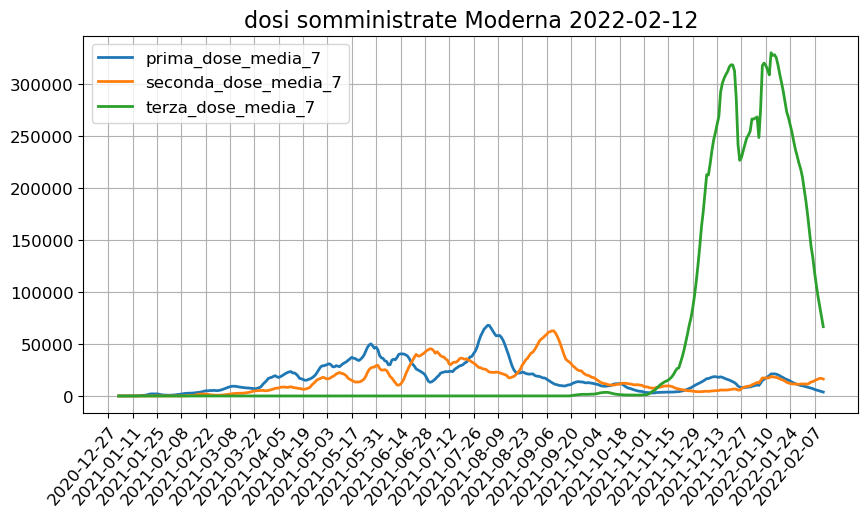

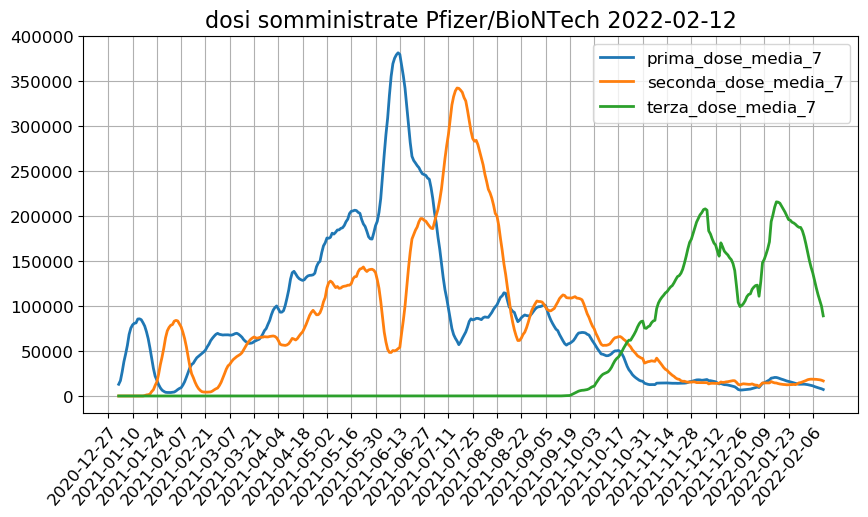

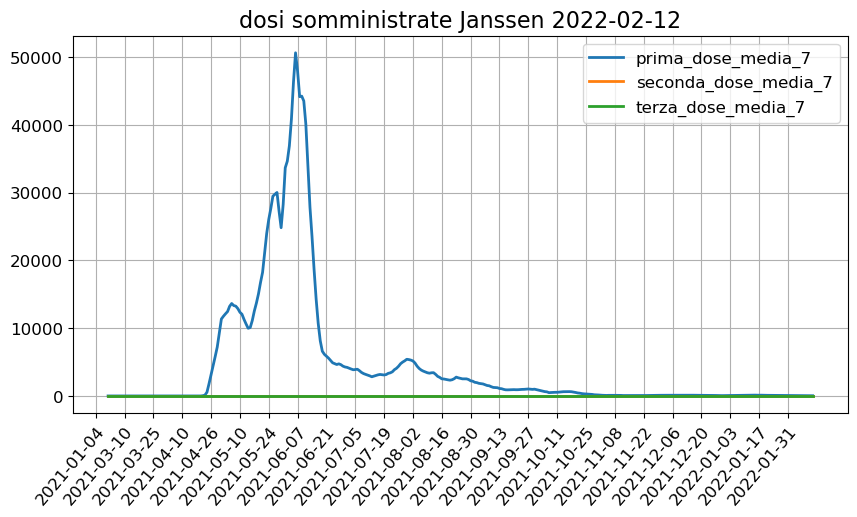

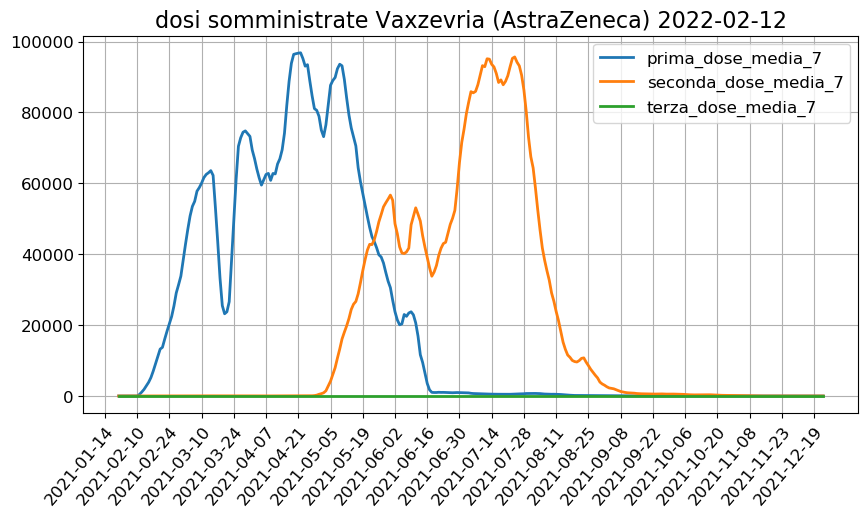

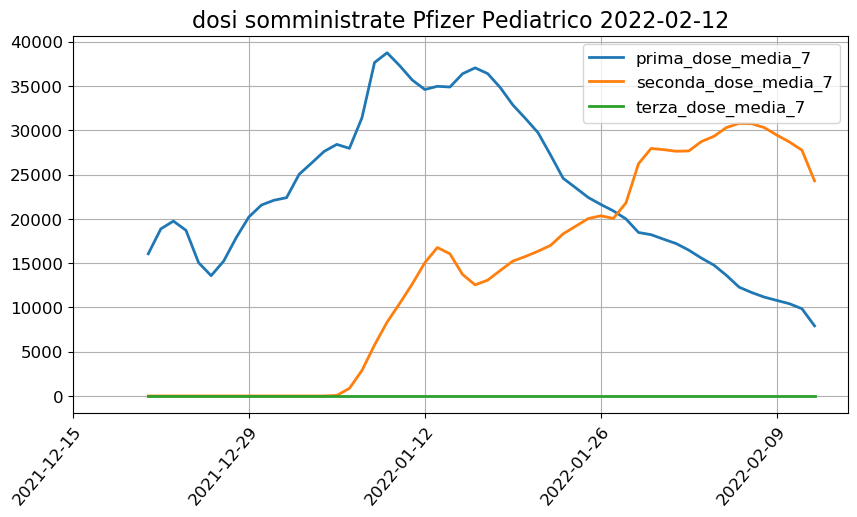

In [14]:
for fornitore in fornitori:
    savename_suffix="_"+fornitore.replace("/","_")
    df_plot = df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore==fornitore]
    df_plot = df_plot.sort_values(by="data_somministrazione")
    df_plot["prima_dose_media_7"] = df_plot["prima_dose"].rolling(7).mean()
    df_plot["seconda_dose_media_7"] = df_plot["seconda_dose"].rolling(7).mean()
    df_plot["terza_dose_media_7"] = df_plot["terza_dose"].rolling(7).mean()
    createXYPlot(df_plot, 
                 y=["prima_dose_media_7","seconda_dose_media_7","terza_dose_media_7"], 
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 figsize_x=10,
                 figsize_y=5,
                 title=f"dosi somministrate {fornitore} {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate{savename_suffix}.png")

In [15]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [16]:
np.sum(df_vax_yyyy_mm_dd[df_vax_yyyy_mm_dd.data_somministrazione>"2021-12-26"][["prima_dose_adulti"]])

prima_dose_adulti    1213956.0
dtype: float64

In [17]:
cond = (df_vax_yyyy_mm_dd_anag.data_somministrazione>"2021-12-26") & (df_vax_yyyy_mm_dd_anag.fascia_anagrafica.isin(["50-59","60-69","70-79","80-89","90+"])) 
    
display(df_vax_yyyy_mm_dd_anag[cond][["data_somministrazione","fascia_anagrafica","prima_dose"]])

np.sum(df_vax_yyyy_mm_dd_anag[cond][["prima_dose"]])

data_somministrazione fascia_anagrafica  prima_dose
3297            2021-12-27             50-59        2770
3298            2021-12-27             60-69        1723
3299            2021-12-27             70-79         981
3300            2021-12-27             80-89         403
3301            2021-12-27               90+          87
3307            2021-12-28             50-59        3166
3308            2021-12-28             60-69        1960
3309            2021-12-28             70-79        1146
3310            2021-12-28             80-89         567
3311            2021-12-28               90+         151
3317            2021-12-29             50-59        3224
3318            2021-12-29             60-69        2078
3319            2021-12-29             70-79        1238
3320            2021-12-29             80-89         601
3321            2021-12-29               90+         178
3327            2021-12-30             50-59        3347
3328            2021-12-30             60-69        2198
3329            2021-12-30             70-79        1328
3330            2021-12-30             80-89         628
3331            2021-12-30               90+         193
3337            2021-12-31             50-59        1669
3338            2021-12-31             60-69         975
3339            2021-12-31             70-79         512
3340            2021-12-31             80-89         255
3341            2021-12-31               90+          73
3347            2022-01-01             50-59         418
3348            2022-01-01             60-69         221
3349            2022-01-01             70-79         111
3350            2022-01-01             80-89          44
3351            2022-01-01               90+           7
3357            2022-01-02             50-59        1791
3358            2022-01-02             60-69         928
3359            2022-01-02             70-79         456
3360            2022-01-02             80-89         251
3361            2022-01-02               90+          48
3367            2022-01-03             50-59        4047
3368            2022-01-03             60-69        2405
3369            2022-01-03             70-79        1264
3370            2022-01-03             80-89         565
3371            2022-01-03               90+         154
3377            2022-01-04             50-59        4261
3378            2022-01-04             60-69        2688
3379            2022-01-04             70-79        1458
3380            2022-01-04             80-89         721
3381            2022-01-04               90+         194
3387            2022-01-05             50-59        3859
3388            2022-01-05             60-69        2411
3389            2022-01-05             70-79        1436
3390            2022-01-05             80-89         677
3391            2022-01-05               90+         215
3397            2022-01-06             50-59        2713
3398            2022-01-06             60-69        1595
3399            2022-01-06             70-79         782
3400            2022-01-06             80-89         371
3401            2022-01-06               90+          64
3407            2022-01-07             50-59        7091
3408            2022-01-07             60-69        4870
3409            2022-01-07             70-79        2813
3410            2022-01-07             80-89        1112
3411            2022-01-07               90+         269
3417            2022-01-08             50-59        6585
3418            2022-01-08             60-69        4641
3419            2022-01-08             70-79        2623
3420            2022-01-08             80-89        1110
3421            2022-01-08               90+         221
3427            2022-01-09             50-59        4982
3428            2022-01-09             60-69        3180
3429            2022-01-09             70-79        1629
3430            2022-01-09             80-89         696
3431           

prima_dose    530391
dtype: int64

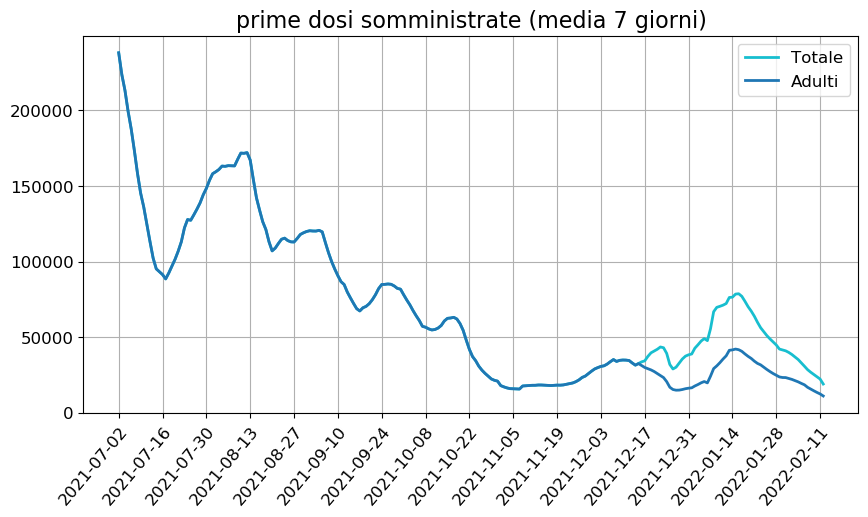

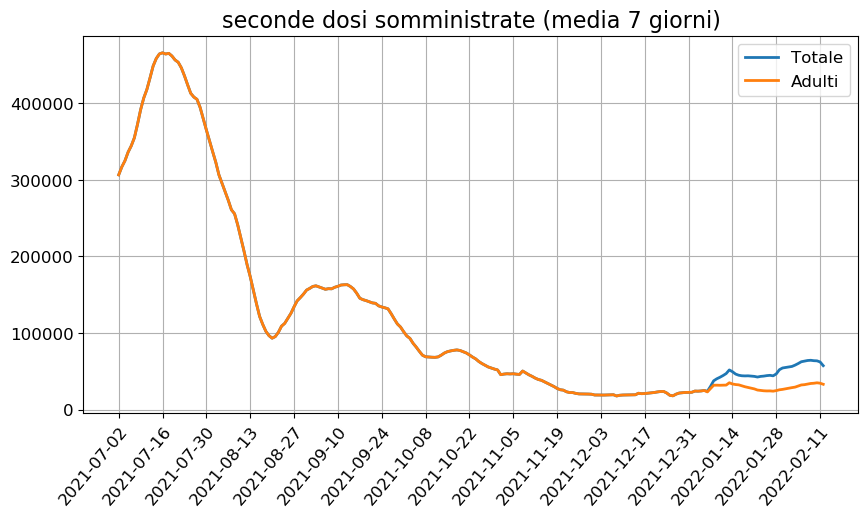

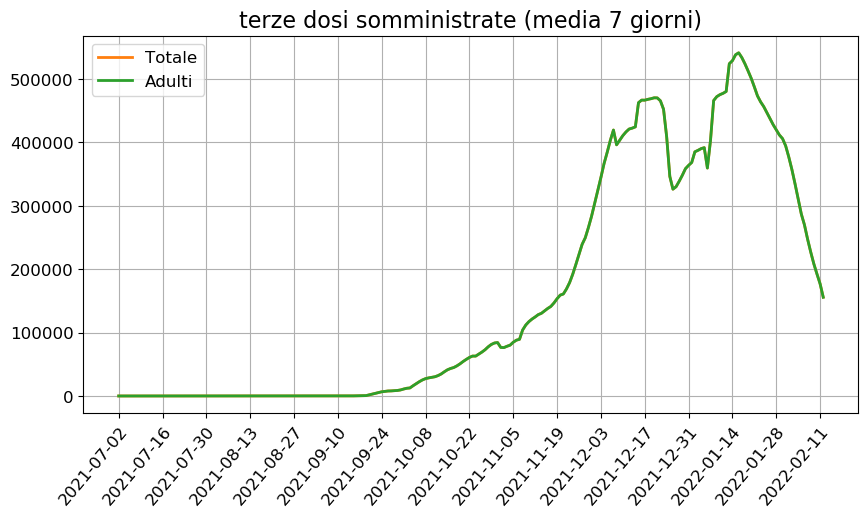

In [18]:
i = 0
for dose in ["prima","seconda","terza"]:
    
    createXYPlot(df_vax_yyyy_mm_dd, 
                 y=[
                    f"{dose}_dose_media_7",
                    f"{dose}_dose_adulti_media_7",
                    
                   ],
                 labels=["Totale","Adulti"],
                 colors=[colors[i-1],colors[i]],
                 alphas=[1,1],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 start_date="2021-07-01",
                 title=f"{dose.replace('a','e')} dosi somministrate (media 7 giorni)",
                 plots_folder=plots_folder,
                 savename=f"{dose.replace('a','e')}_dosi_somministrate.png"
                )
    i +=1

In [19]:
df_vax_yyyy_mm_dd[["data_somministrazione","prima_dose","terza_dose"]].tail(10)

data_somministrazione  prima_dose  terza_dose
403            2022-02-03       28421      274629
404            2022-02-04       29164      268373
405            2022-02-05       36095      247864
406            2022-02-06       20632      115878
407            2022-02-07       20861      200057
408            2022-02-08       21828      186010
409            2022-02-09       19579      166032
410            2022-02-10       18223      162181
411            2022-02-11       18249      160361
412            2022-02-12       13138      100248

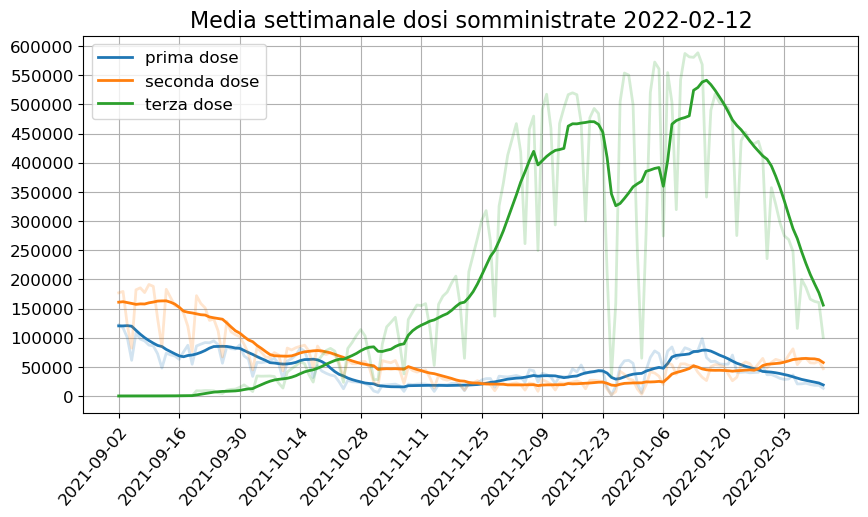

In [39]:
createXYPlot(df_vax_yyyy_mm_dd, 
                 y=["prima_dose",
                    "prima_dose_media_7",
                    "seconda_dose",
                    "seconda_dose_media_7",
                    "terza_dose",
                    "terza_dose_media_7"], 
                 labels=[None,
                         "prima dose",
                         None,
                         "seconda dose",
                         None,
                         "terza dose"],
                 alphas=[0.2,1,0.2,1,0.2,1],
                 colors=[colors[0],colors[0],
                         colors[1],colors[1],
                         colors[2],colors[2]],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 title=f"Media settimanale dosi somministrate {oggi}",
                 plots_folder=plots_folder,
                 yticks=range(0,650000,50000),
                 start_date="2021-09-01",
                 savename=f"dosi_somministrate_media7")

In [21]:
df_vax_yyyy_mm_dd["totale_prima_dose"] = df_vax_yyyy_mm_dd["prima_dose"].cumsum()
df_vax_yyyy_mm_dd["totale_prima_dose_no_guariti"] = df_vax_yyyy_mm_dd["prima_dose_no_guariti"].cumsum()
df_vax_yyyy_mm_dd["totale_seconda_dose"] = df_vax_yyyy_mm_dd["seconda_dose"].cumsum()
df_vax_yyyy_mm_dd["totale_terza_dose"] = df_vax_yyyy_mm_dd["terza_dose"].cumsum()
df_vax_yyyy_mm_dd["totale_pregressa_infezione"] = df_vax_yyyy_mm_dd["pregressa_infezione"].cumsum()

In [22]:
df_vax_yyyy_mm_dd_fornitore["totale_prima_dose"] = df_vax_yyyy_mm_dd_fornitore.groupby("fornitore")["prima_dose"].cumsum()
df_vax_yyyy_mm_dd_fornitore["totale_seconda_dose"] = df_vax_yyyy_mm_dd_fornitore.groupby("fornitore")["seconda_dose"].cumsum()
df_vax_yyyy_mm_dd_fornitore["totale_terza_dose"] = df_vax_yyyy_mm_dd_fornitore.groupby("fornitore")["terza_dose"].cumsum()


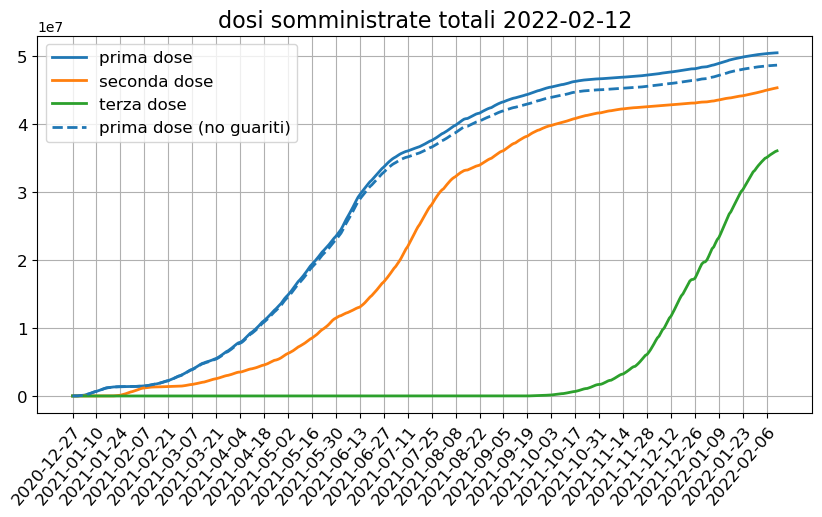

In [41]:
createXYPlot(df_vax_yyyy_mm_dd, 
             y=["totale_prima_dose",
                "totale_seconda_dose",
                "totale_terza_dose", 
                "totale_prima_dose_no_guariti"], 
             labels=["prima dose", 
                     "seconda dose", 
                     "terza dose", 
                     "prima dose (no guariti)"
                    ],
             linestyles=["-","-","-","dashed"],
             colors=[colors[0],colors[1],colors[2],colors[0]],
             x="data_somministrazione", 
             days_interval=14,
             linewidth=2,
             title=f"dosi somministrate totali {oggi}",
             plots_folder=plots_folder,
             savename=f"dosi_somministrate_cumulativo.png"
            )

### Cumulativa per fornitore

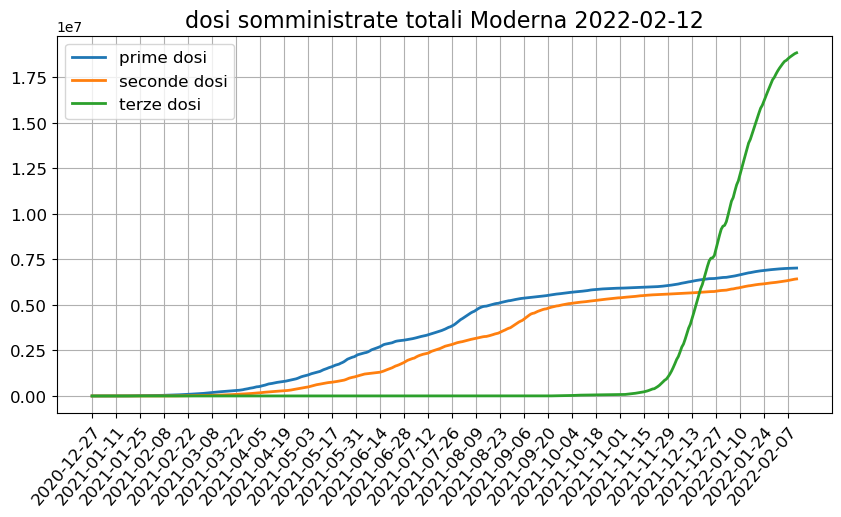

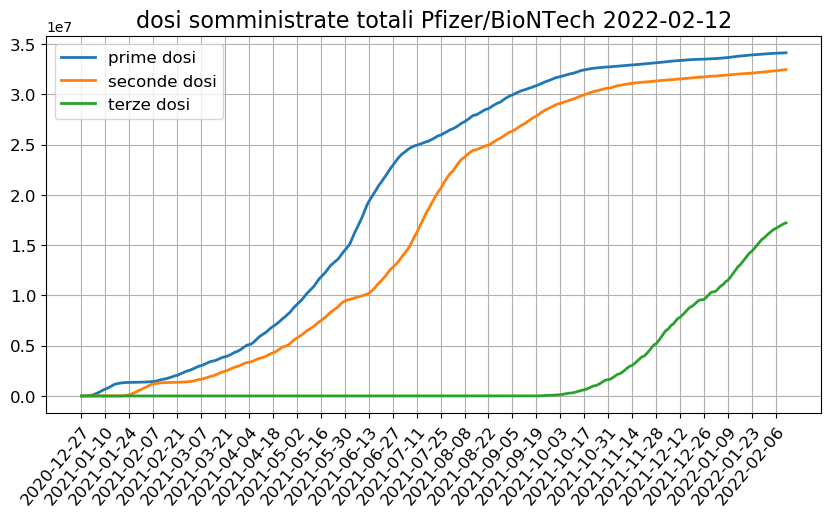

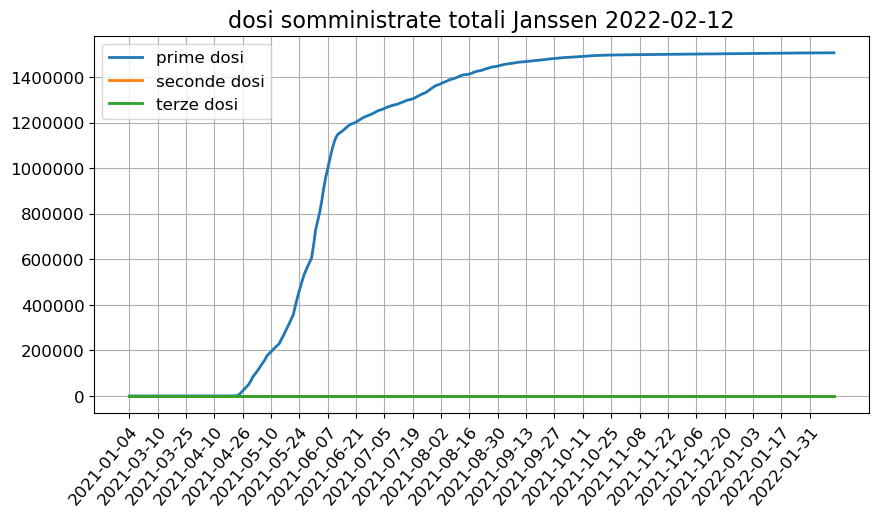

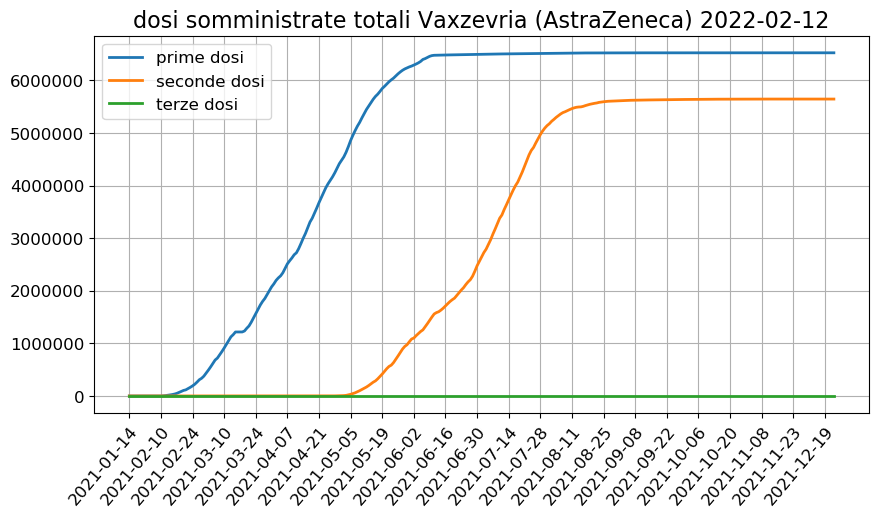

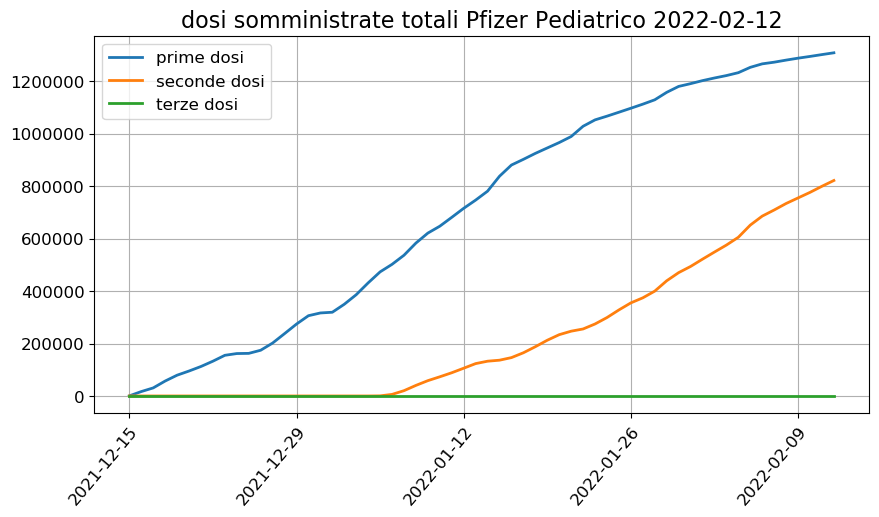

In [24]:
for fornitore in fornitori:
    df_plot = df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore==fornitore]
    savename_suffix="_"+fornitore.replace("/","_")    
    createXYPlot(df_plot, 
                 y=["totale_prima_dose","totale_seconda_dose","totale_terza_dose"],
                 labels=["prime dosi","seconde dosi", "terze dosi"],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 title=f"dosi somministrate totali {fornitore} {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate_totali_{savename_suffix}.png")

In [25]:
df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag["fascia_anagrafica"]=="05-11"].tail(3)

data_somministrazione fascia_anagrafica  prima_dose  seconda_dose  \
3742            2022-02-10             05-11        6649         21179   
3752            2022-02-11             05-11        7033         23226   
3762            2022-02-12             05-11        6815         22112   

      terza_dose  pregressa_infezione  prima_dose_no_guariti  \
3742           0                   77                   6572   
3752           0                   81                   6952   
3762           0                  105                   6710   

      prima_dose_media_7  seconda_dose_media_7  terza_dose_media_7  \
3742        10420.285714          28688.714286                 0.0   
3752         9851.000000          27759.142857                 0.0   
3762         7919.285714          24291.714286                 0.0   

      prima_dose_no_guariti_media_7  
3742                   10310.000000  
3752                    9744.714286  
3762                    7826.142857

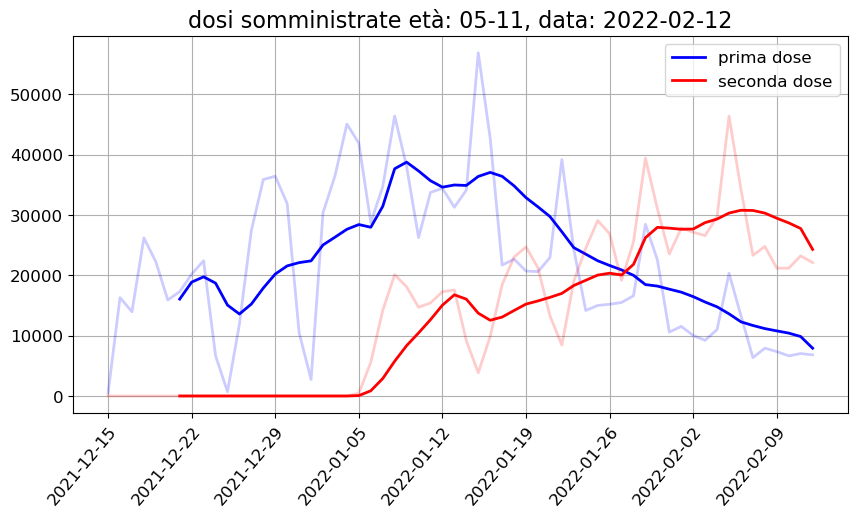

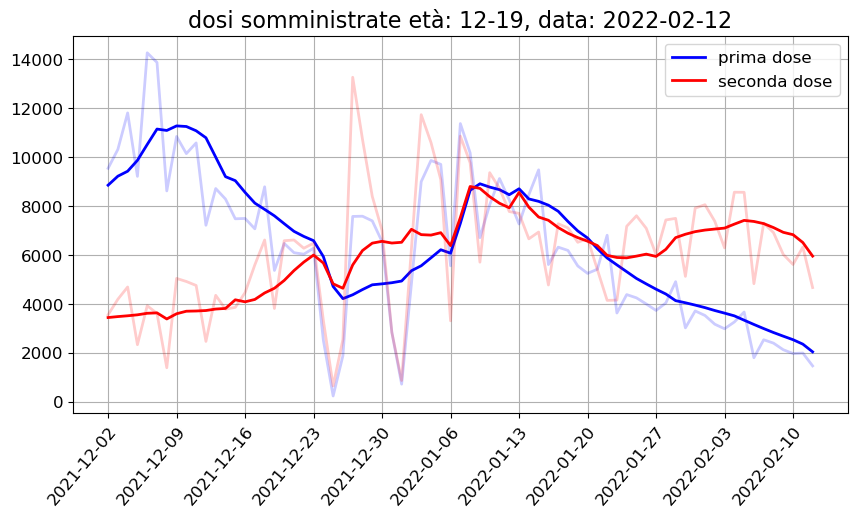

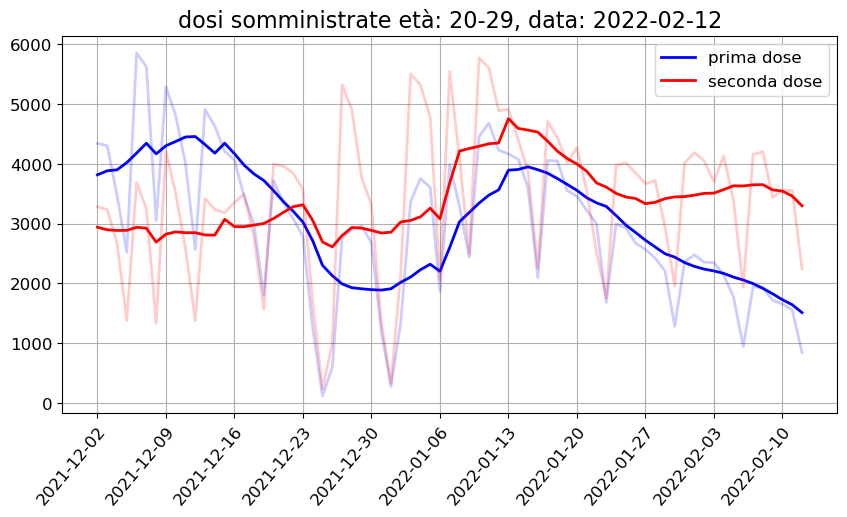

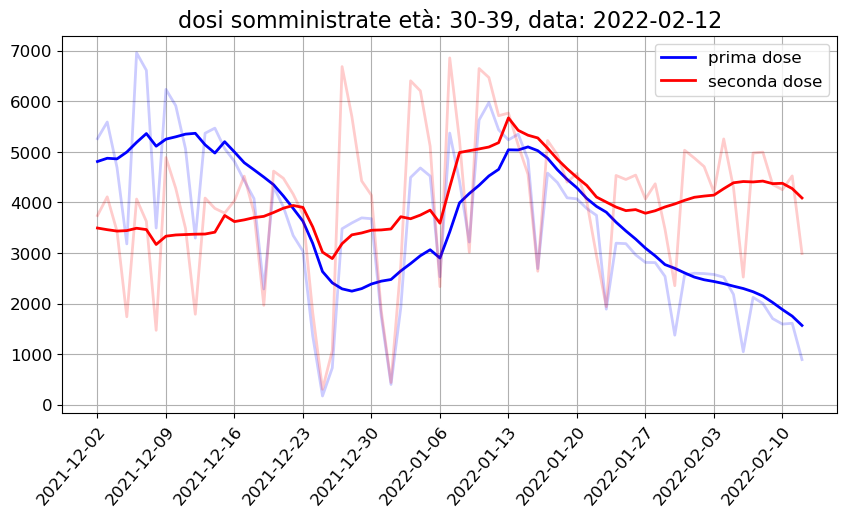

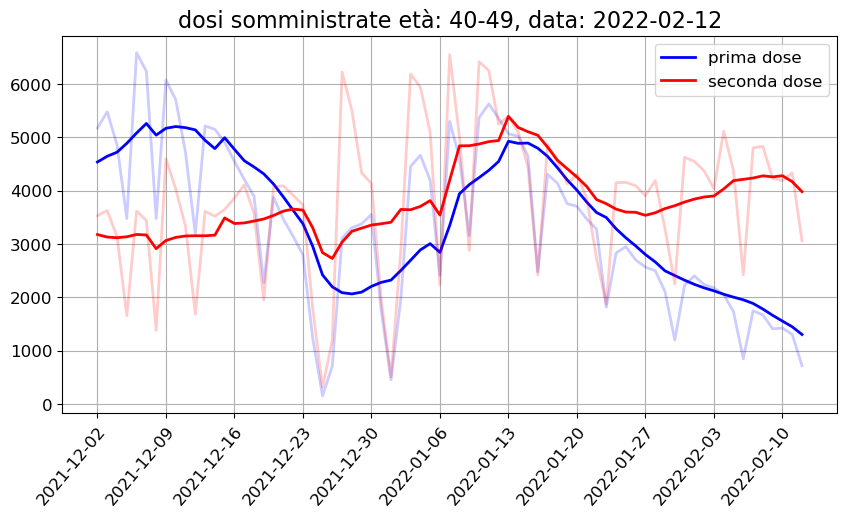

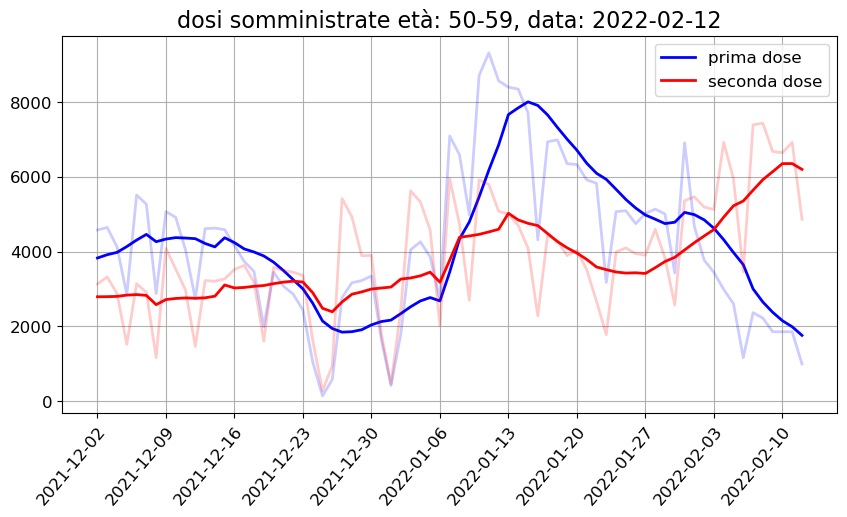

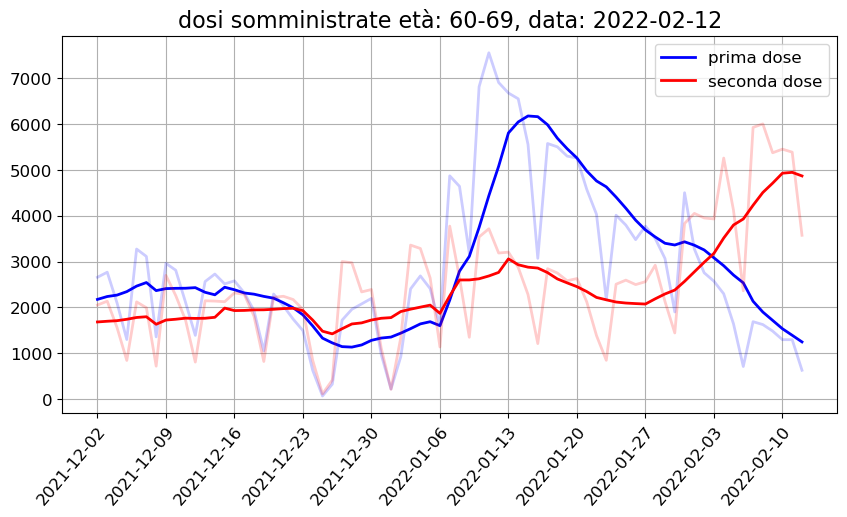

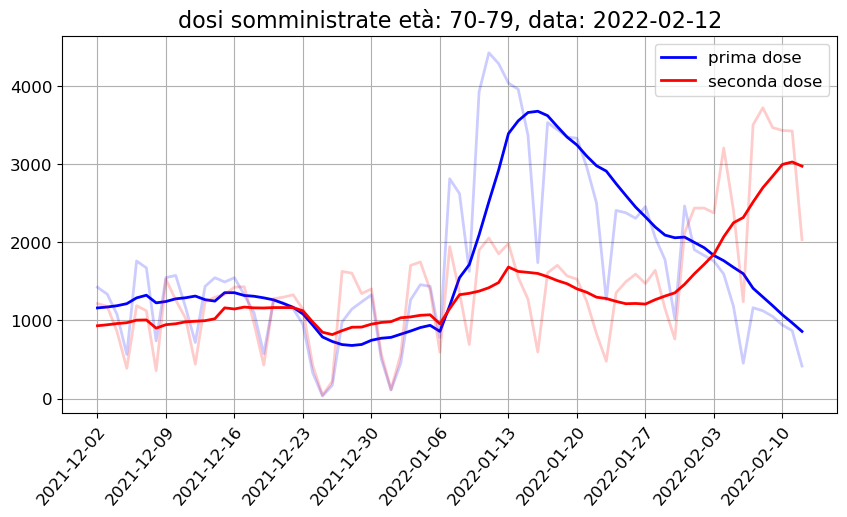

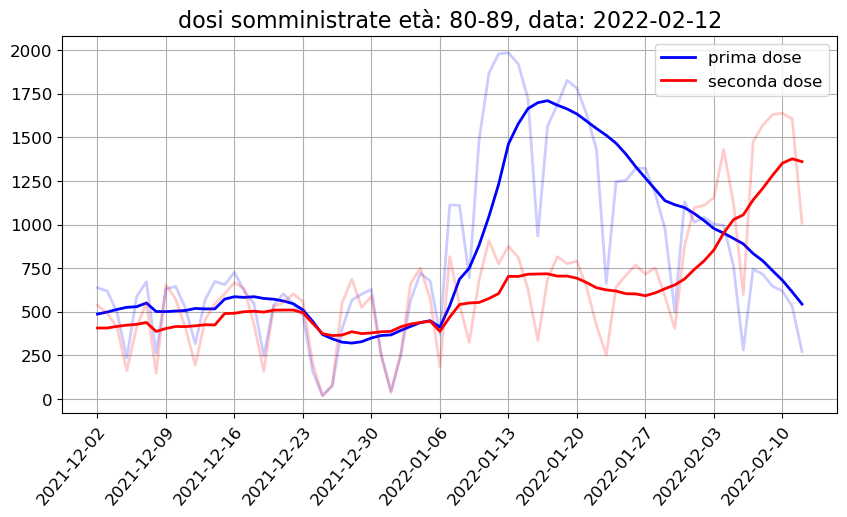

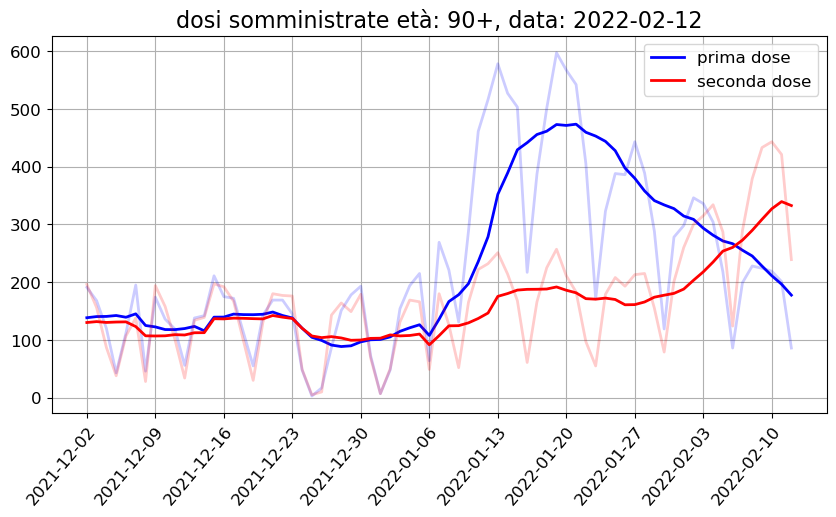

In [26]:
for anag in sorted(df_vax_yyyy_mm_dd_anag["fascia_anagrafica"].unique()):
    savename_suffix="_" + anag  
    df_plot = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica==anag]
    df_plot = df_plot.sort_values(by="data_somministrazione")
    createXYPlot(df_plot, 
                 y=["prima_dose", "prima_dose_media_7", "seconda_dose", "seconda_dose_media_7"], 
                 labels=[None, "prima dose", None, "seconda dose"],
                 colors=["b","b","r","r"],
                 alphas=[0.2,1,0.2,1],
                 x="data_somministrazione", 
                 linewidth=2,
                 days_interval=7,
                 start_date="2021-12-01",
                 title=f"dosi somministrate età: {anag}, data: {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate{savename_suffix}.png")


In [27]:
grid = get_grid(keys=["data_somministrazione","fascia_anagrafica"])

In [28]:
df_vax_yyyy_mm_dd_anag = grid.merge(df_vax_yyyy_mm_dd_anag, on=["data_somministrazione","fascia_anagrafica"], how="left")
df_vax_yyyy_mm_dd_anag = df_vax_yyyy_mm_dd_anag.fillna(0)

In [31]:
def dosi_eta(media=True, 
             start_date="2021-10-01",
             days_interval=7
            ):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for dose in ["prima","seconda","terza"]:
        plt.figure(dpi=100,figsize=(11,5))
        col_idx = 0
        for anag in sorted(df_vax_yyyy_mm_dd_anag["fascia_anagrafica"].unique()):
            df_plot = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica==anag]
            df_plot = df_plot[df_plot.data_somministrazione>=start_date]
            x = df_plot["data_somministrazione"].tolist()
            x = [ x[i] for i in range(0,len(x)) if i % days_interval == 0]
            if media:
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose"], alpha=0.2, color=colors[col_idx])
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose_media_7"], label=anag, color=colors[col_idx], linewidth=2.0)
            else:
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose"], alpha=1, label=anag, color=colors[col_idx])

            col_idx +=1
        plt.xticks(x, rotation=60, 
                   rotation_mode="anchor", 
                   verticalalignment = "top", 
                   horizontalalignment = "right",
                   fontsize=12
                  )
        plt.yticks(fontsize=12)
        plt.yscale("log")
        plt.grid()
        plt.legend()
        if dose == "prima":
            title = "Prime dosi"
        elif dose == "seconda":
            title = "Seconde dosi"
        else:
            title = "Terze dosi"
        plt.title(f"{title} somministrate per fascia d'età",fontsize=16)
        savename=f"{plots_folder}/{dose}_dose_fascia_eta"
        if media:
            savename += "_media"
        plt.savefig(fname=f"{savename}.png",bbox_inches="tight")

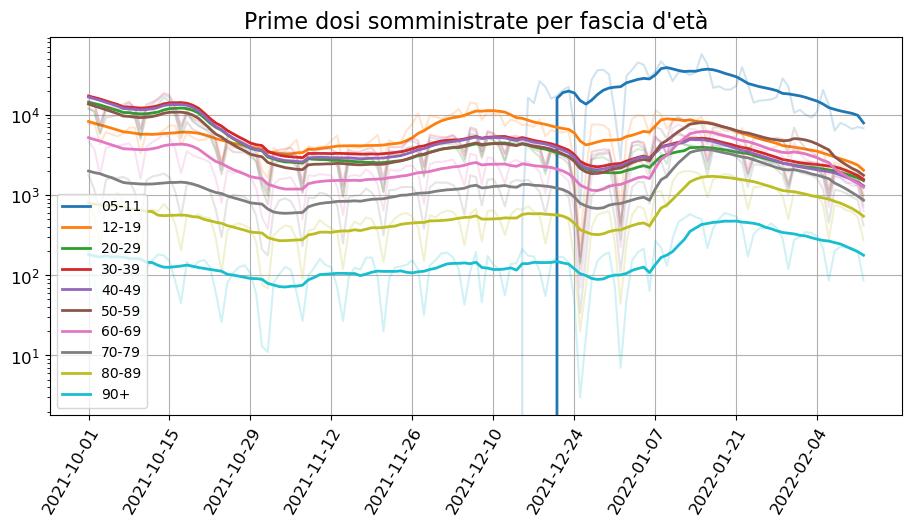

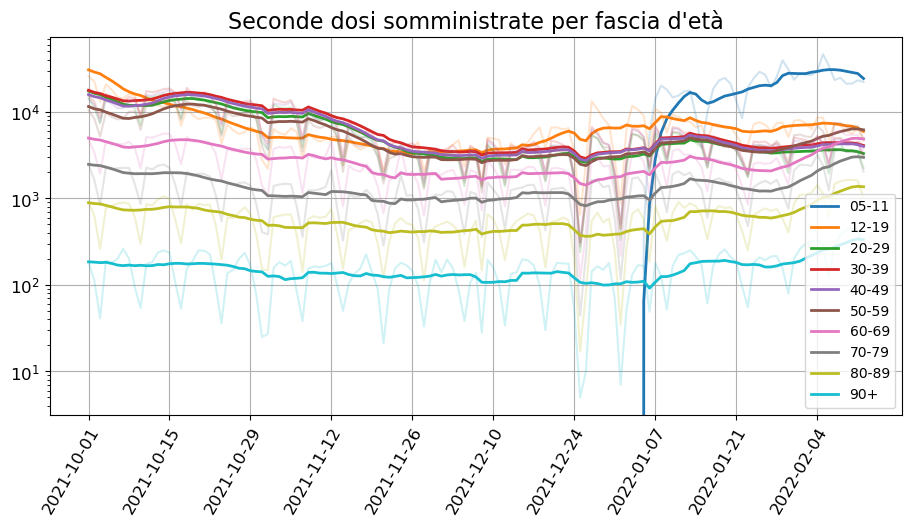

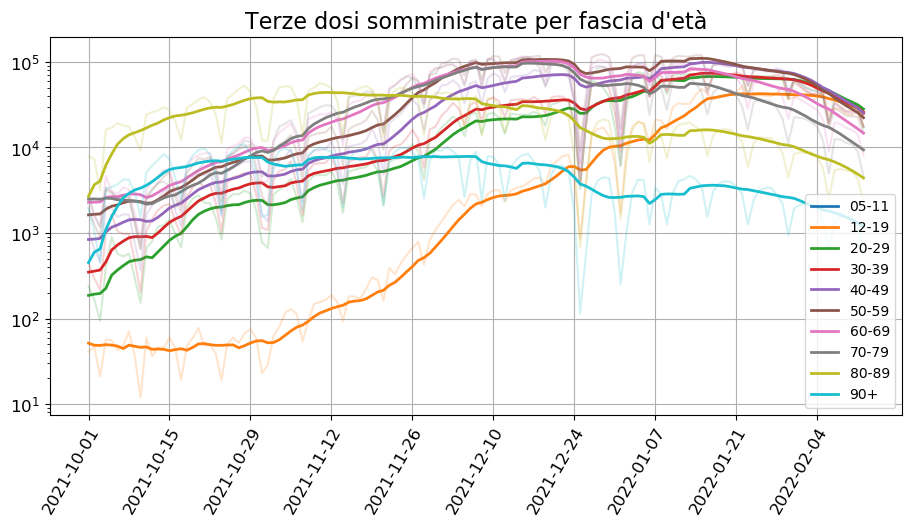

In [32]:
dosi_eta(media=True, start_date="2021-10-01", days_interval=14)

In [37]:
grid = get_grid(keys=["data_somministrazione", "fascia_anagrafica","fornitore"])

In [38]:
df_vax_yyyy_mm_dd_anag_fornitore = grid.merge(df_vax_yyyy_mm_dd_anag_fornitore, on=["data_somministrazione", "fascia_anagrafica","fornitore"],how="left")
df_vax_yyyy_mm_dd_anag_fornitore = df_vax_yyyy_mm_dd_anag_fornitore.fillna(0)

In [39]:
df_vax_yyyy_mm_dd_anag_fornitore[df_vax_yyyy_mm_dd_anag_fornitore.fascia_anagrafica=="05-11"]

data_somministrazione fascia_anagrafica                fornitore  \
0                2020-12-27             05-11                  Janssen   
1                2020-12-27             05-11                  Moderna   
2                2020-12-27             05-11        Pfizer Pediatrico   
3                2020-12-27             05-11          Pfizer/BioNTech   
4                2020-12-27             05-11  Vaxzevria (AstraZeneca)   
...                     ...               ...                      ...   
20450            2022-02-09             05-11                  Janssen   
20451            2022-02-09             05-11                  Moderna   
20452            2022-02-09             05-11        Pfizer Pediatrico   
20453            2022-02-09             05-11          Pfizer/BioNTech   
20454            2022-02-09             05-11  Vaxzevria (AstraZeneca)   

       prima_dose  seconda_dose  terza_dose  pregressa_infezione  \
0             0.0           0.0         0.0                  0.0   
1             0.0           0.0         0.0                  0.0   
2             0.0           0.0         0.0                  0.0   
3             0.0           0.0         0.0                  0.0   
4             0.0           0.0         0.0                  0.0   
...           ...           ...         ...                  ...   
20450         0.0           0.0         0.0                  0.0   
20451         0.0           0.0         0.0                  0.0   
20452      6966.0       20550.0         0.0                 90.0   
20453         0.0           0.0         0.0                  0.0   
20454         0.0           0.0         0.0                  0.0   

       prima_dose_no_guariti  prima_dose_media_7  seconda_dose_media_7  \
0                        0.0            0.000000              0.000000   
1                        0.0            0.000000              0.000000   
2                        0.0            0.000000              0.000000   
3                        0.0            0.000000              0.000000   
4                        0.0            0.000000              0.000000   
...                      ...                 ...                   ...   
20450                    0.0            0.000000              0.000000   
20451                    0.0            0.000000              0.000000   
20452                 6876.0        10726.285714          29322.571429   
20453                    0.0            0.000000              0.000000   
20454                    0.0            0.000000              0.000000   

       terza_dose_media_7  prima_dose_no_guariti_media_7  
0                     0.0                       0.000000  
1                     0.0                       0.000000  
2                     0.0                       0.000000  
3                     0.0                       0.000000  
4                     0.0                       0.000000  
...                   ...                            ...  
20450                 0.0                       0.000000  
20451                 0.0                       0.000000  
20452                 0.0                   10614.428571  
20453                 0.0                       0.000000  
20454                 0.0                       0.000000  

[2050 rows x 12 columns]

In [40]:
def plot_anag_fornitore(start_date, media=False):
    for dose in ["prima","seconda","terza"]:
        for fornitore in fornitori:
            plt.figure(dpi=100, figsize=(10,4))
            max_val_0 = 0
            col_idx = 0
            for anag in anagrafiche:
                condizione = (df_vax_yyyy_mm_dd_anag_fornitore.fornitore == fornitore) & (df_vax_yyyy_mm_dd_anag_fornitore.fascia_anagrafica==anag)
                df_plot = df_vax_yyyy_mm_dd_anag_fornitore[condizione]
                df_plot = df_plot[df_plot.data_somministrazione>=start_date]
                Xval = df_plot["data_somministrazione"]
                Yval = df_plot[f"{dose}_dose"]
                Yval_media7 = df_plot[f"{dose}_dose_media_7"]
                if media:
                    plt.plot(Xval, Yval, linewidth=1.8, alpha=0.15, color=colors[col_idx])
                    plt.plot(Xval, Yval_media7, label=anag, linewidth=2.0, color=colors[col_idx])
                else:
                    plt.plot(Xval, Yval, linewidth=1.8, alpha=1, color=colors[col_idx],label=anag)
                max_val = np.max(Yval)
                col_idx += 1
                if max_val > max_val_0:
                    max_val_0 = max_val
            x = df_plot["data_somministrazione"].tolist()
            x = [ x[i] for i in range(0,len(x)) if i % 7 == 0]
            plt.xticks(x, rotation=60, 
                       rotation_mode="anchor", 
                       verticalalignment = "top", 
                       horizontalalignment = "right",
                       fontsize=12
                      )
            plt.yticks(fontsize=12)
            plt.grid()
            plt.legend()
            if dose == "prima":
                title = "Prime dosi"
            elif dose == "seconda":
                title = "Seconde dosi"
            else:
                title = "Terze dosi"
            title = f"{title} somministrate per fascia d'età"
            if media:
                title += ", media 7 giorni, "
            title += f" {fornitore}"
            savename = f"{plots_folder}/{dose}_dose_{fornitore.replace('/','_')}_eta"
            if media:
                savename += "_media7"
            savename += ".png"
            plt.title(title, fontsize=16)
            plt.savefig(fname=savename,bbox_inches="tight")

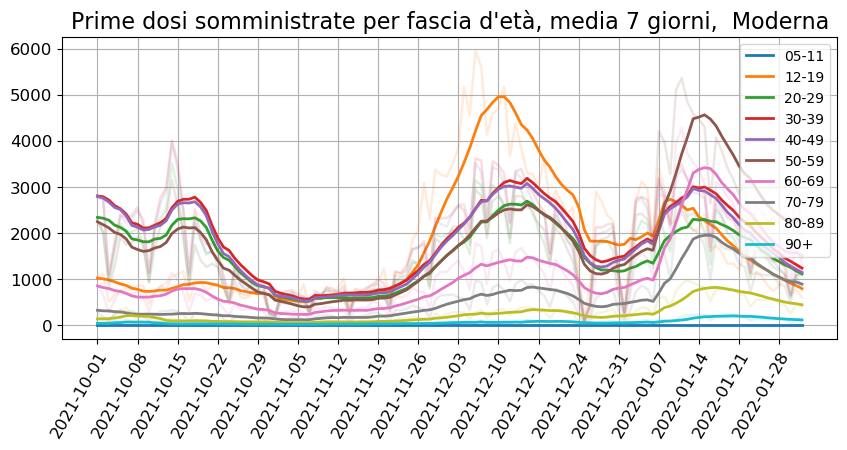

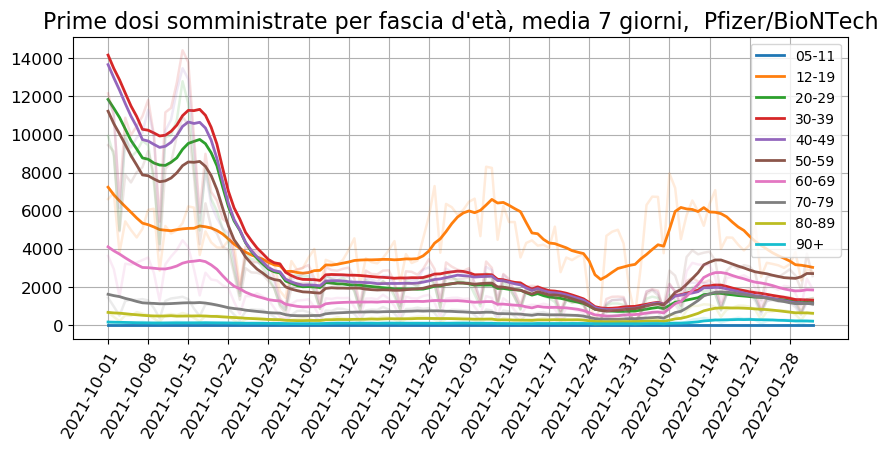

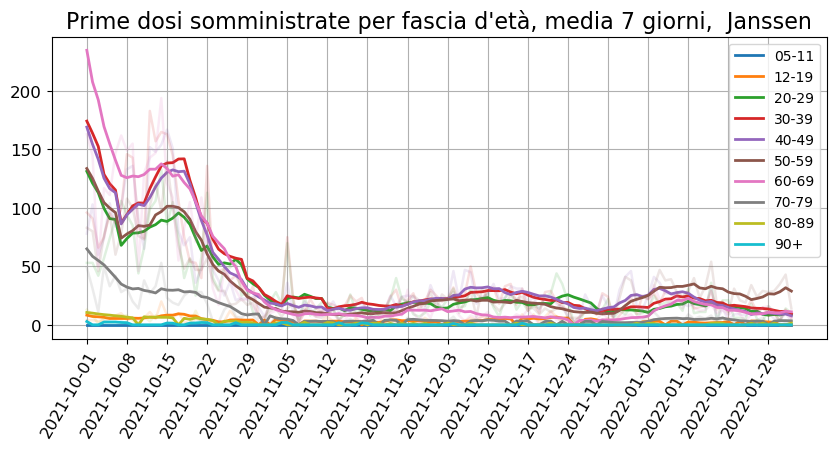

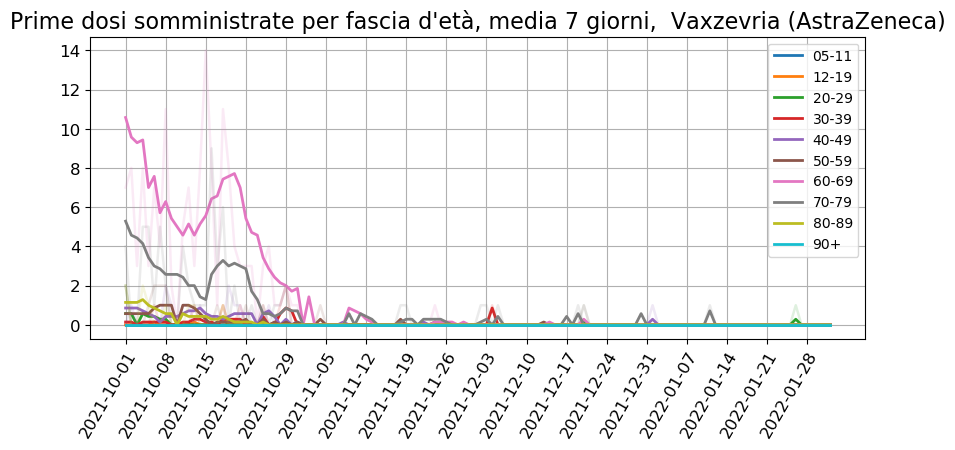

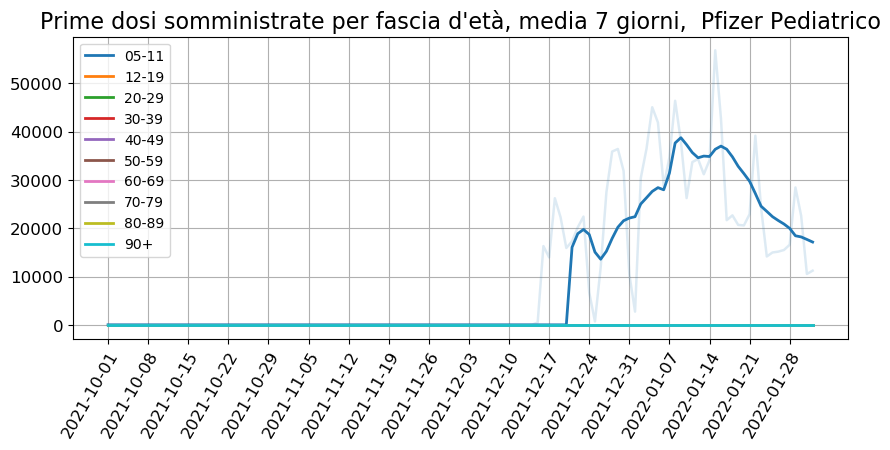

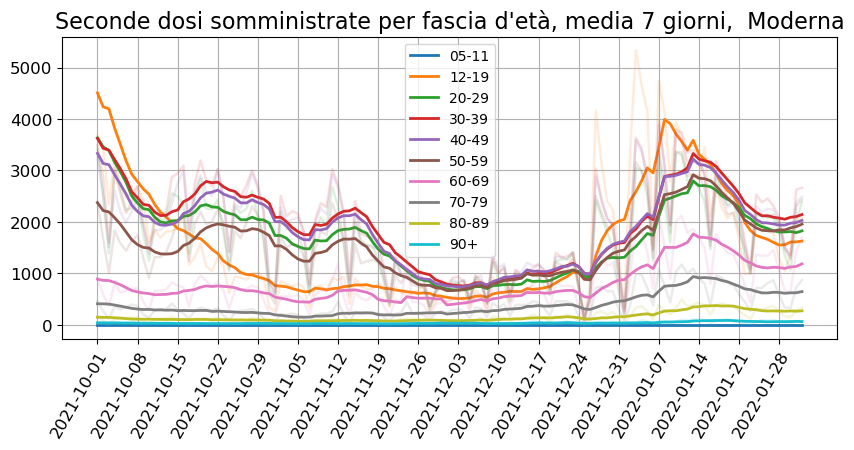

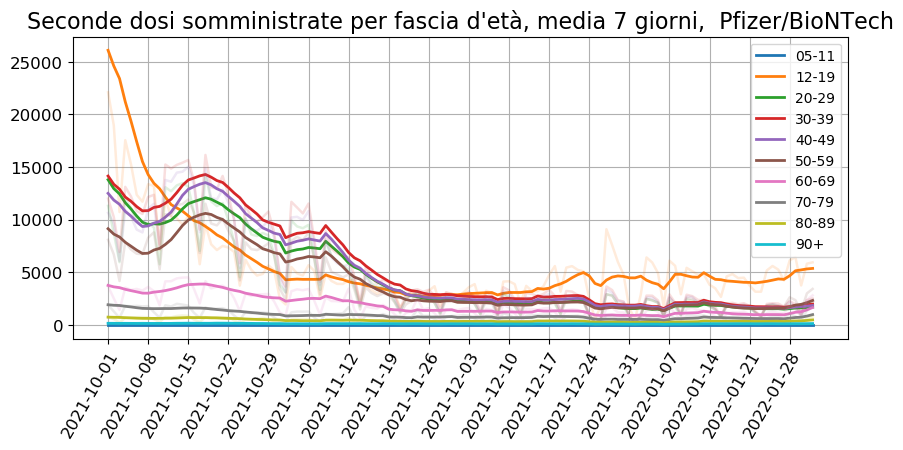

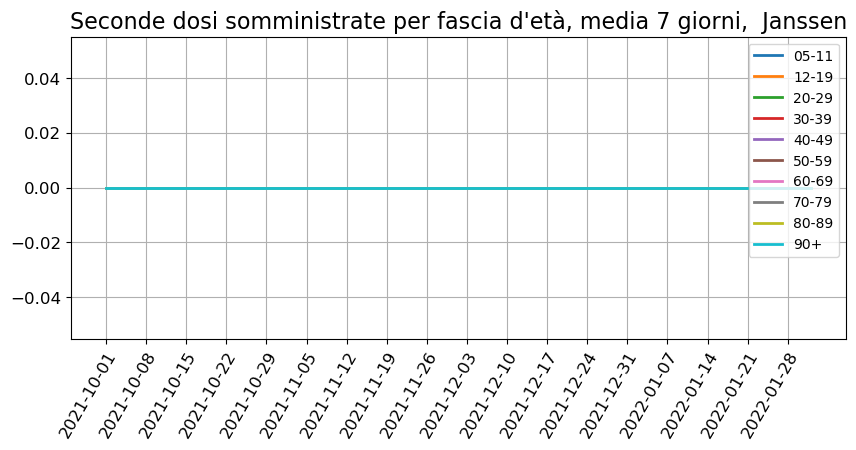

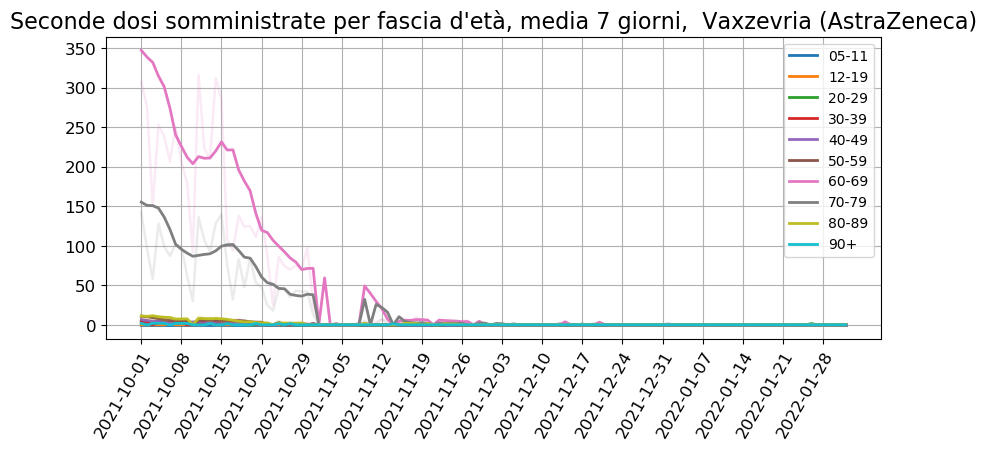

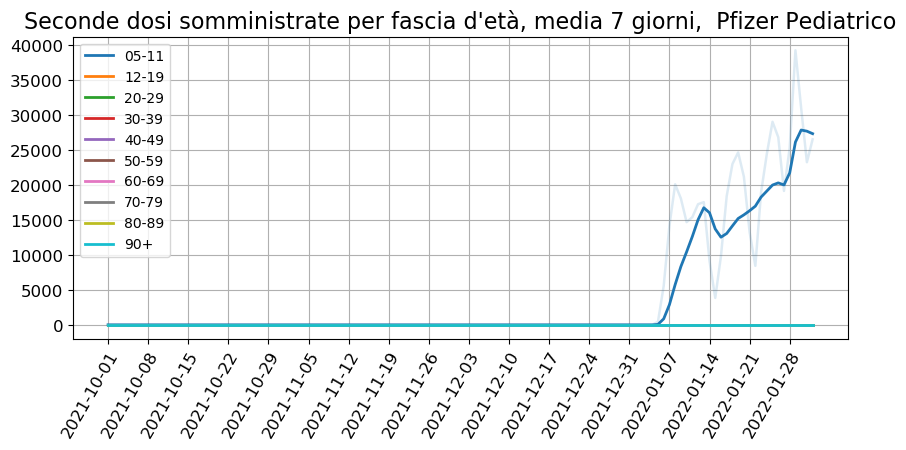

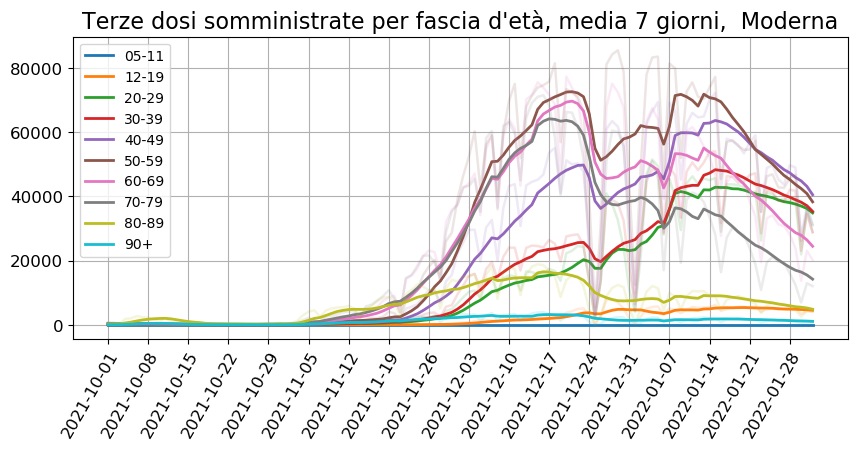

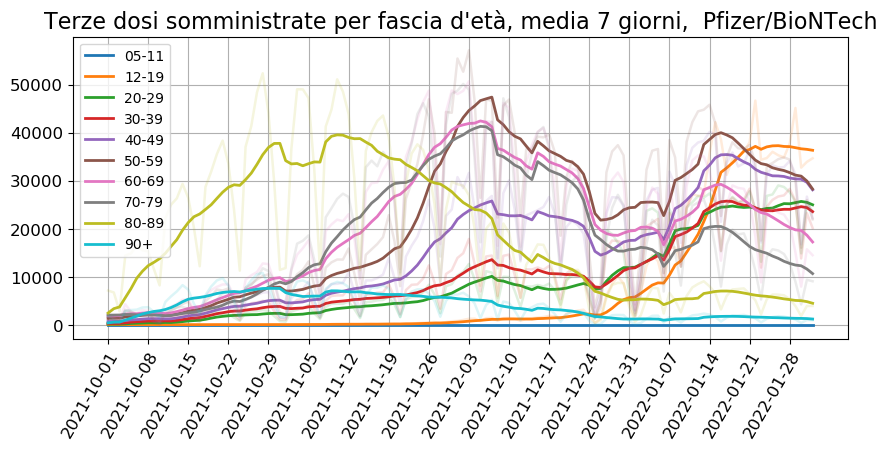

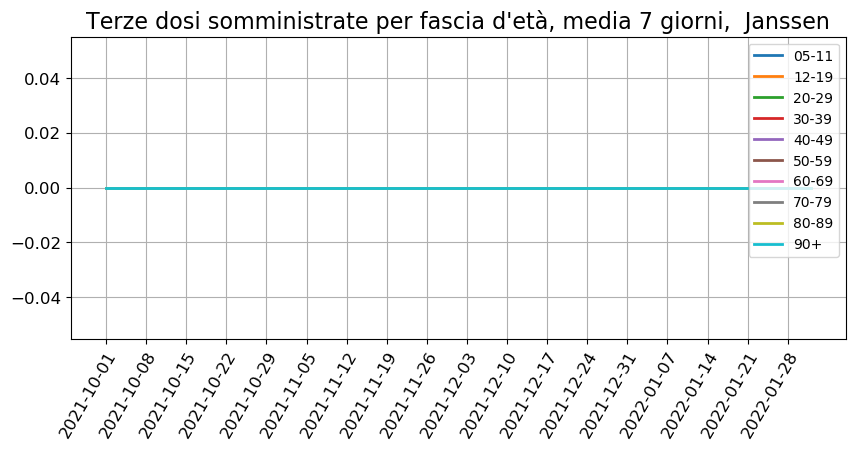

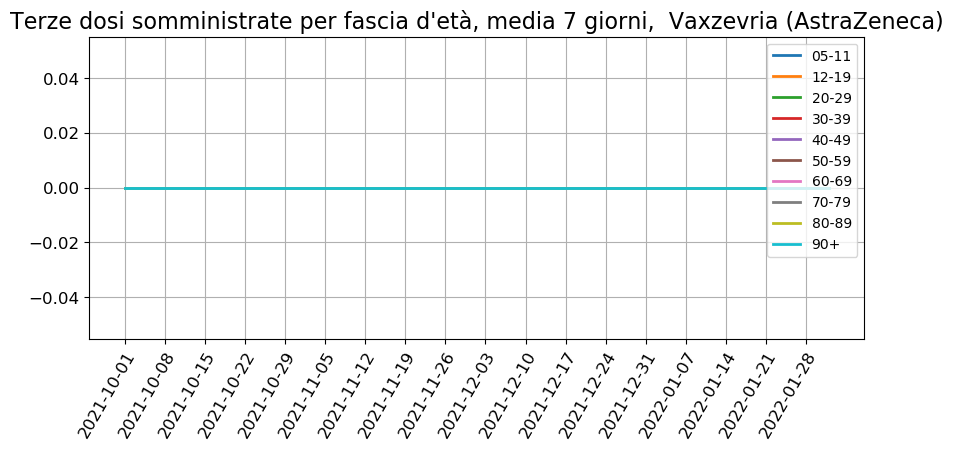

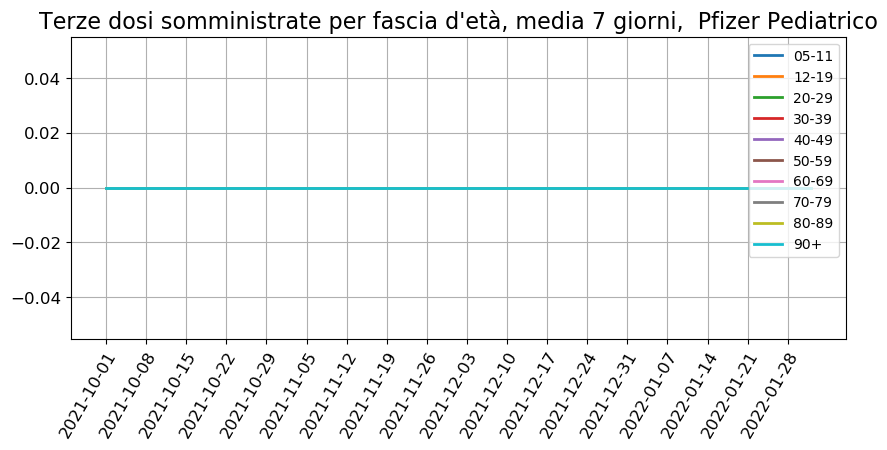

In [34]:
plot_anag_fornitore(start_date="2021-10-01", media=True)

In [35]:
popolazione = pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/platea.csv")
popolazione = popolazione.groupby("fascia_anagrafica").sum().reset_index()

In [36]:
np.sum(popolazione["totale_popolazione"])

57666014

In [37]:
pop_over_50 = popolazione[popolazione.fascia_anagrafica.isin(["50-59","60-69","70-79","80+"])]
display(pop_over_50)
np.sum(pop_over_50["totale_popolazione"])

fascia_anagrafica  totale_popolazione
5             50-59             9645296
6             60-69             7552718
7             70-79             6016425
8               80+             4589183

27803622

In [38]:
prime_dosi_over_50 = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica.isin(["50-59","60-69","70-79","80-89","90+"])][["data_somministrazione","fascia_anagrafica","prima_dose"]]
np.sum(prime_dosi_over_50["prima_dose"])

25915412.0

In [39]:
df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore=="Janssen"]

data_somministrazione fornitore  prima_dose  seconda_dose  terza_dose  \
15              2021-01-04   Janssen           9             0           0   
18              2021-01-05   Janssen           2             0           0   
21              2021-01-06   Janssen           2             0           0   
24              2021-01-07   Janssen           2             0           0   
33              2021-01-11   Janssen           3             0           0   
85              2021-02-02   Janssen           1             0           0   
92              2021-02-04   Janssen           4             0           0   
99              2021-02-06   Janssen           1             0           0   
105             2021-02-08   Janssen           2             0           0   
169             2021-03-01   Janssen           1             0           0   
185             2021-03-06   Janssen           2             0           0   
189             2021-03-07   Janssen           1             0           0   
193             2021-03-08   Janssen           6             0           0   
197             2021-03-09   Janssen           1             0           0   
201             2021-03-10   Janssen           3             0           0   
205             2021-03-11   Janssen           6             0           0   
209             2021-03-12   Janssen           7             0           0   
213             2021-03-13   Janssen           5             0           0   
217             2021-03-14   Janssen           5             0           0   
221             2021-03-15   Janssen           9             0           0   
225             2021-03-16   Janssen          14             0           0   
229             2021-03-17   Janssen          22             0           0   
233             2021-03-18   Janssen          14             0           0   
237             2021-03-19   Janssen          12             0           0   
241             2021-03-20   Janssen           5             0           0   
245             2021-03-21   Janssen           3             0           0   
252             2021-03-23   Janssen           7             0           0   
256             2021-03-24   Janssen           1             0           0   
260             2021-03-25   Janssen           2             0           0   
264             2021-03-26   Janssen           6             0           0   
268             2021-03-27   Janssen           4             0           0   
272             2021-03-28   Janssen           1             0           0   
279             2021-03-30   Janssen           3             0           0   
283             2021-03-31   Janssen          17             0           0   
287             2021-04-01   Janssen           7             0           0   
291             2021-04-02   Janssen           3             0           0   
295             2021-04-03   Janssen           3             0           0   
302             2021-04-05   Janssen           7             0           0   
306             2021-04-06   Janssen          55             0           0   
310             2021-04-07   Janssen           5             0           0   
314             2021-04-08   Janssen           8             0           0   
318             2021-04-09   Janssen          26             0           0   
322             2021-04-10   Janssen           5             0           0   
326             2021-04-11   Janssen           4             0           0   
330             2021-04-12   Janssen           7             0           0   
334             2021-04-13   Janssen           8             0           0   
338             2021-04-14   Janssen           2             0           0   
345             2021-04-16   Janssen           2             0           0   
352             2021-04-18   Janssen           1             0           0   
356             2021-04-19   Janssen           2             0           0   
360             2021-04-20 

In [40]:
display(df_vax_yyyy_mm_dd[df_vax_yyyy_mm_dd.data_somministrazione=="2021-08-05"][["data_somministrazione","totale_seconda_dose","totale_pregressa_infezione"]])
display(df_vax_yyyy_mm_dd_fornitore[(df_vax_yyyy_mm_dd_fornitore.data_somministrazione=="2021-08-05") & (df_vax_yyyy_mm_dd_fornitore.fornitore=="Janssen")][["data_somministrazione","fornitore","totale_prima_dose"]])
display(df_vax_yyyy_mm_dd[df_vax_yyyy_mm_dd.data_somministrazione=="2021-08-05"][["data_somministrazione","totale_seconda_dose"]])

data_somministrazione  totale_seconda_dose  totale_pregressa_infezione
221            2021-08-05             31704810                     1063138

data_somministrazione fornitore  totale_prima_dose
788            2021-08-05   Janssen            1382106

data_somministrazione  totale_seconda_dose
221            2021-08-05             31704810

In [41]:
from datetime import datetime, timedelta
datetime.strftime(datetime.strptime("2022-02-01","%Y-%m-%d") - timedelta(180),"%Y-%m-%d")

'2021-08-05'

In [42]:
1061638+1381975+31700161

34143774

In [43]:
df_vax_yyyy_mm_dd[["data_somministrazione","totale_terza_dose"]].tail(10)

data_somministrazione  totale_terza_dose
392            2022-01-23           30343320
393            2022-01-24           30780127
394            2022-01-25           31231529
395            2022-01-26           31665875
396            2022-01-27           32096715
397            2022-01-28           32531565
398            2022-01-29           32941822
399            2022-01-30           33176197
400            2022-01-31           33529798
401            2022-02-01           33842101

In [44]:
34143774 - 32910171

1233603

In [45]:
df_vax_yyyy_mm_dd["booster_eligibility"] = df_vax_yyyy_mm_dd["data_somministrazione"].apply(lambda x: datetime.strptime(x,"%Y-%m-%d") + timedelta(120)) 